important libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from prophet import Prophet

load_data

In [3]:
df = pd.read_csv("GlobalLandTemperaturesByCountry.csv", encoding='utf-8')

In [4]:
df.head()

,Date,Date2,Country,AverageTemperature,AverageTemperatureUncertainty
0,1970-01-01,19700101,Ã…land,-6.495,0.584
1,1970-01-01,19700101,Afghanistan,1.337,0.327
2,1970-01-01,19700101,Africa,21.995,0.182
3,1970-01-01,19700101,Albania,5.382,0.309
4,1970-01-01,19700101,Algeria,14.470,0.350


preprocessing

In [5]:
df=df.drop(columns=['Date2'])
df=df.drop(columns=['AverageTemperatureUncertainty'])
df=df.drop(columns=['Country'])


In [6]:

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Sort data by date
df = df.sort_index()

# Drop missing values (if any)
df.dropna(inplace=True)

# Display first few rows
print(df.head())


            AverageTemperature
Date                          
1970-01-01              -6.495
1970-01-01               1.337
1970-01-01              21.995
1970-01-01               5.382
1970-01-01              14.470


check if data staionary or not

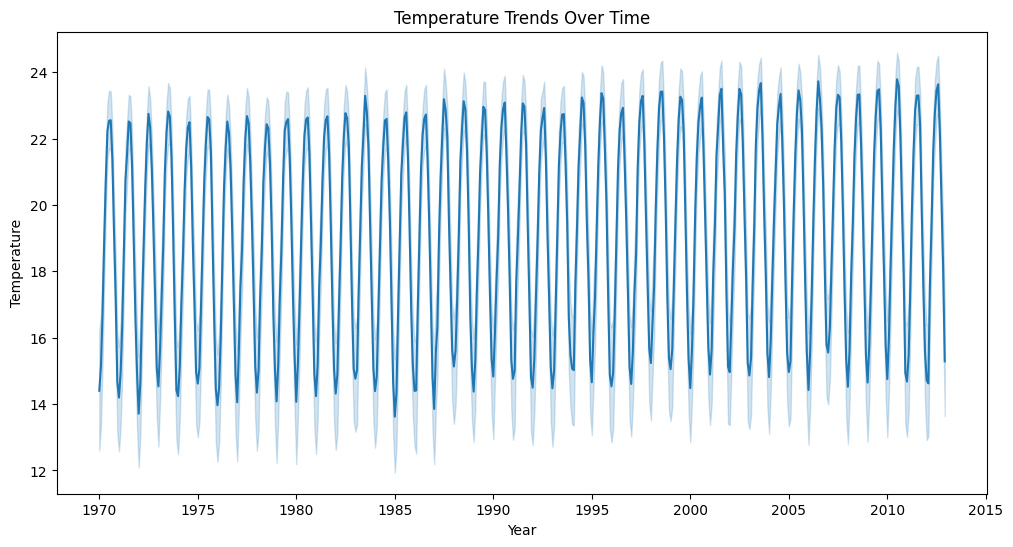

In [7]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x=df.index, y="AverageTemperature")
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.title("Temperature Trends Over Time")
plt.show()

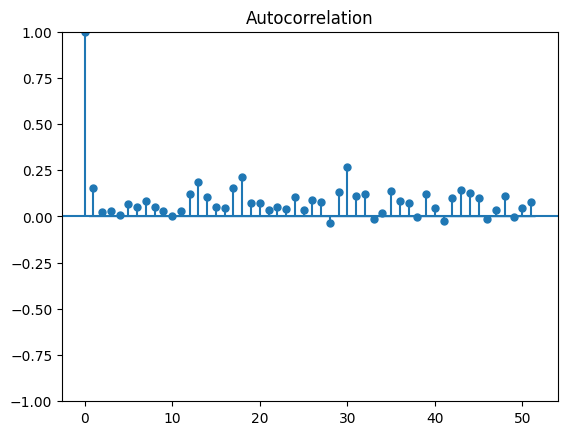

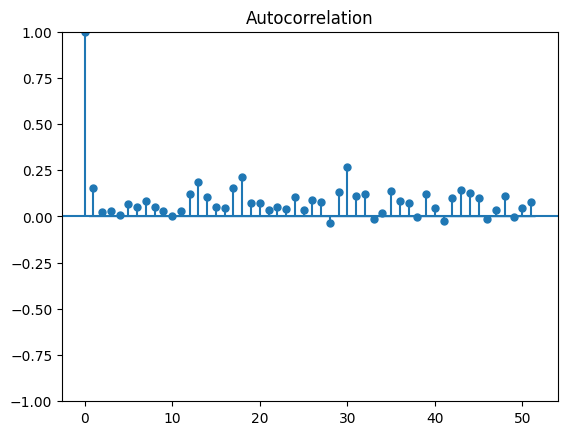

In [8]:
plot_acf(df['AverageTemperature'])

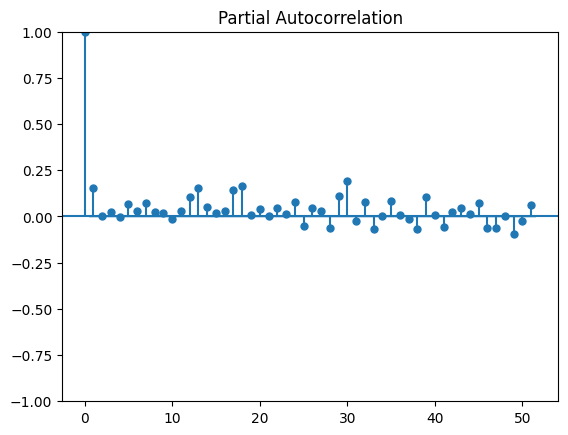

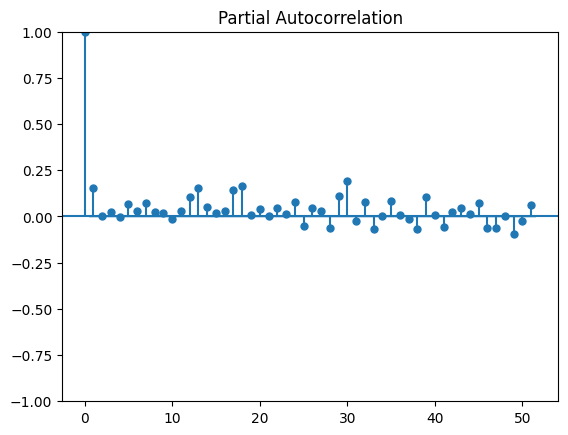

In [9]:
plot_pacf(df['AverageTemperature'])



In [10]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

interpret_dftest(adfuller(df['AverageTemperature']))

Test Statistic   -1.395175e+01
p-value           4.688456e-26
dtype: float64

split_data

In [11]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

ARIMA & prophet model

c:\Users\Ahmed fawzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ahmed fawzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ahmed fawzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ahmed fawzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Max

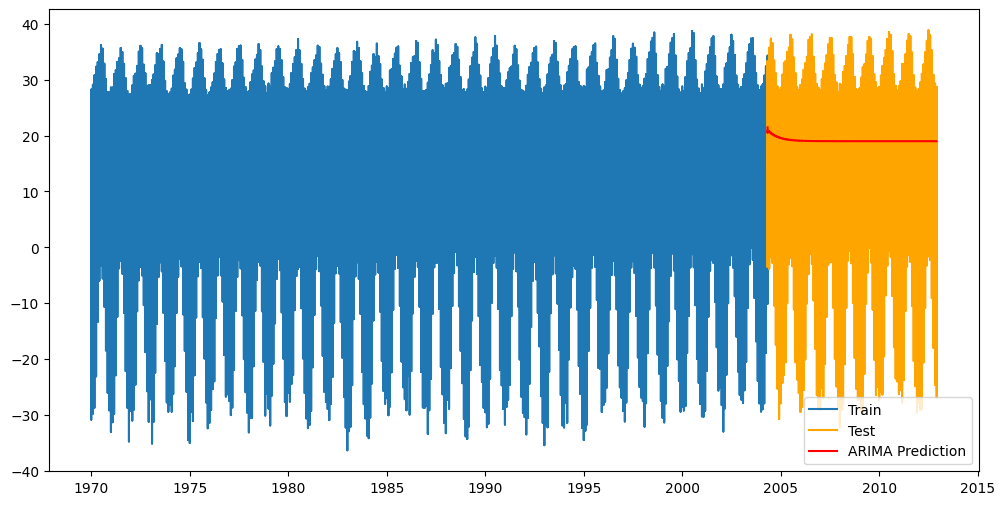

In [22]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['AverageTemperature'], order=(2,0,2))  # Adjust (p,d,q) as needed
arima_model = model.fit()

# Forecast future values
forecast = arima_model.forecast(steps=len(test))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train.index, train['AverageTemperature'], label="Train")
plt.plot(test.index, test['AverageTemperature'], label="Test", color='orange')
plt.plot(test.index, forecast, label="ARIMA Prediction", color='red')
plt.legend()
plt.show()

In [23]:
test.loc[:, 'predicted_temperature'] = forecast.values  

# Compute R² score
r2 = r2_score(test['AverageTemperature'], test['predicted_temperature'])
print(f"ARIMA R² Score: {r2:.4f}")

ARIMA R² Score: -0.0013


C:\Users\Ahmed fawzi\AppData\Local\Temp\ipykernel_7440\2834828198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'predicted_temperature'] = forecast.values


00:16:43 - cmdstanpy - INFO - Chain [1] start processing
00:16:50 - cmdstanpy - INFO - Chain [1] done processing


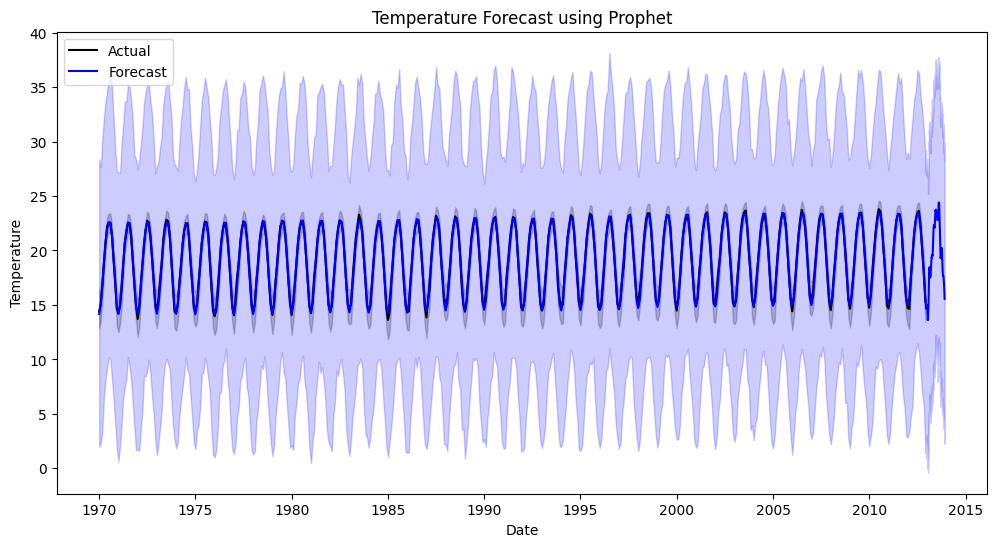

In [20]:
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,  # Disable if not needed
    daily_seasonality=False
)
prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Add monthly seasonality
prophet_model.fit(prophet_df)

# Create future dataframe for 1 year ahead
future = prophet_model.make_future_dataframe(periods=365)

# Make predictions
forecast = prophet_model.predict(future)

# Plot forecast with seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=prophet_df, x="ds", y="y", label="Actual", color="black")
sns.lineplot(data=forecast, x="ds", y="yhat", label="Forecast", color="blue")
plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], color='blue', alpha=0.2)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature Forecast using Prophet")
plt.legend()
plt.show()

00:27:16 - cmdstanpy - INFO - Chain [1] start processing
00:27:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet R² Score: -0.0929


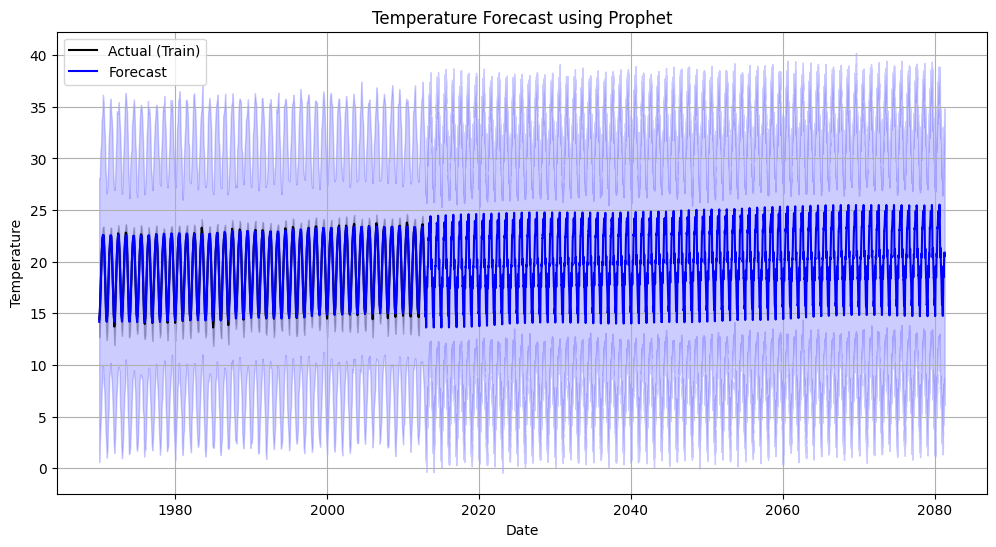

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import r2_score

# Ensure test DataFrame is modifiable
test = test.copy()

# Initialize Prophet model with seasonality
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,  # Disable if not needed
    daily_seasonality=False
)
prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Add monthly seasonality

# Fit model
prophet_model.fit(prophet_df)

# Create future dataframe for 1 year ahead
future = prophet_model.make_future_dataframe(periods=len(test))  # Match test size

# Make predictions
forecast = prophet_model.predict(future)

# Merge predictions with test data
test.loc[:, 'predicted_temperature'] = forecast.iloc[-len(test):]['yhat'].values  

# Compute R² score
r2 = r2_score(test['AverageTemperature'], test['predicted_temperature'])
print(f"Prophet R² Score: {r2:.4f}")

# Plot forecast with seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=prophet_df, x="ds", y="y", label="Actual (Train)", color="black")
sns.lineplot(data=forecast, x="ds", y="yhat", label="Forecast", color="blue")
plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], color='blue', alpha=0.2)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature Forecast using Prophet")
plt.legend()
plt.grid()
plt.show()
